In [30]:
 #!wget "https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47"
 #!mv "$(ls -Art | head -1)" mal.zip

!pip install gdown
#upgrade
!pip install --upgrade gdown



import gdown
# a file
file_id = "1k0YAc-r5jT3Hym04EcMOA0fRBq7nQb-n"
url = f"https://drive.google.com/uc?id={file_id}"
output = "mal.zip"

gdown.download(url, output, quiet=False)

# Check if download was successful
if os.path.exists(output):
    print("✅ File downloaded successfully.")

    # Unzip the file
    !unzip -o mal.zip

    # Remove .DS_Store if they exist (macOS metadata files)
    !rm -f mal_data/train/.DS_Store
    !rm -f mal_data/test/.DS_Store
else:
    print("❌ File download failed. Check the file ID or permissions.")

Downloading...
From (original): https://drive.google.com/uc?id=1k0YAc-r5jT3Hym04EcMOA0fRBq7nQb-n
From (redirected): https://drive.google.com/uc?id=1k0YAc-r5jT3Hym04EcMOA0fRBq7nQb-n&confirm=t&uuid=60c2d3db-d5d3-4cc8-a2d4-3c216f7f5845
To: /content/mal.zip
100%|██████████| 2.44G/2.44G [00:24<00:00, 101MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: mal_data/train/Zbot/49f9785d5a42b3daa95d7d91ab077e669f7116c8.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._49f9785d5a42b3daa95d7d91ab077e669f7116c8.exe  
  inflating: mal_data/train/Zbot/daf40516a7c465ebbcaea190707a04bf6af1a2e5.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._daf40516a7c465ebbcaea190707a04bf6af1a2e5.exe  
  inflating: mal_data/train/Zbot/42547c95702e0c5c846e4e5ecac6db6ac8c22175.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._42547c95702e0c5c846e4e5ecac6db6ac8c22175.exe  
  inflating: mal_data/train/Zbot/39940afa60287af35d90db68fc6396d0c20b74d0.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._39940afa60287af35d90db68fc6396d0c20b74d0.exe  
  inflating: mal_data/train/Zbot/d7c51263bd3beec0fcefa2d94589530450b5e1bd.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._d7c51263bd3beec0fcefa2d94589530450b5e1bd.exe  
  inflating: mal_data/train/Zbot/21891ae5ca1d7146a8df57aa7c89b7234b099ff7.exe  
  inflating: _

- Installs gdown to download files from Google Drive.

- Downloads and unzips a dataset archive (mal.zip), which contains malware sample data for training/testing.

- Cleans up unnecessary macOS .DS_Store files from the directories.

In [31]:
import os
import pickle

import numpy as np

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.
    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

_,class_to_idx = find_classes("mal_data/train")


class MalwareDataset(Dataset):
    def __init__(self, data_path, input_length = 4096, transform=False):
        self.data_path = data_path
        self.input_length = input_length
        _,self.class_to_idx = find_classes(data_path)
        self.malware_files = []
        available_classes = set()
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(data_path, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.malware_files.append(item)

    def __getitem__(self, index):
        item = self.malware_files[index]
        with open(item[0], "rb") as f:
            tmp = [i+1 for i in f.read()[:self.input_length]]
            tmp = tmp+[0]*(self.input_length-len(tmp))
        return np.array(tmp), item[1]

    def __len__(self):
        return len(self.malware_files)



- Defines a PyTorch dataset to load and preprocess malware data.

- find_classes: Reads subfolders as class labels (e.g., malware types).

- MalwareDataset:

  - Reads binary files.

  - Converts each file into a byte array (padded/truncated to input_length).

  - Associates it with the correct class label.

In [32]:
import torch
from torch import nn
from torch.nn import functional as F


# neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv1d(1,4,19,5),
            nn.MaxPool1d(4),
            nn.Flatten(),
            nn.Linear(48, 6)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()


lr=0.001
num_epochs=10
batch_size = 16
input_len = 256 # Number of bytes read from application files (.exe)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_data = MalwareDataset("mal_data/train",input_length = input_len)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = MalwareDataset("mal_data/test",input_length = input_len)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

loss_list = []
acc_list = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (samples, labels) in enumerate(train_loader):
    samples = samples.type(torch.FloatTensor).cuda()
    labels = labels.cuda()

    outputs = model(samples.unsqueeze(1))

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%200 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))



Epoch [1/10], Step [0/437], Loss: 64.2986, Accuracy: 6.25%
Epoch [1/10], Step [200/437], Loss: 2.5747, Accuracy: 62.50%
Epoch [1/10], Step [400/437], Loss: 0.6375, Accuracy: 75.00%
Epoch [2/10], Step [0/437], Loss: 0.6905, Accuracy: 87.50%
Epoch [2/10], Step [200/437], Loss: 1.1637, Accuracy: 75.00%
Epoch [2/10], Step [400/437], Loss: 0.9967, Accuracy: 75.00%
Epoch [3/10], Step [0/437], Loss: 0.6990, Accuracy: 81.25%
Epoch [3/10], Step [200/437], Loss: 1.4036, Accuracy: 81.25%
Epoch [3/10], Step [400/437], Loss: 0.2943, Accuracy: 93.75%
Epoch [4/10], Step [0/437], Loss: 1.1400, Accuracy: 75.00%
Epoch [4/10], Step [200/437], Loss: 0.3122, Accuracy: 93.75%
Epoch [4/10], Step [400/437], Loss: 0.4949, Accuracy: 87.50%
Epoch [5/10], Step [0/437], Loss: 0.6017, Accuracy: 87.50%
Epoch [5/10], Step [200/437], Loss: 0.6847, Accuracy: 93.75%
Epoch [5/10], Step [400/437], Loss: 0.1047, Accuracy: 93.75%
Epoch [6/10], Step [0/437], Loss: 0.4403, Accuracy: 81.25%
Epoch [6/10], Step [200/437], Loss: 

- Defines a 1D CNN model (ConvNet) with:

  - A convolutional layer.

  - Max pooling.

  - Flattening.

  - A final linear layer for classification.

- Trains the model on the malware byte data:

  - Converts input to tensors and runs forward pass.

  - Computes loss and backpropagation.

  - Logs loss and accuracy.

In [33]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for samples, labels in test_loader:
      samples = samples.type(torch.FloatTensor).cuda()
      labels = labels.cuda()

      outputs = model(samples.unsqueeze(1))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the test samples: {} %'.format((correct / total) * 100))

Accuracy of the model on the test samples: 94.41658308258107 %


- Evaluates the trained model on test data.

- Disables gradient tracking for faster inference.

- Calculates overall classification accuracy.

Text(0.5, 1.0, 'loss')

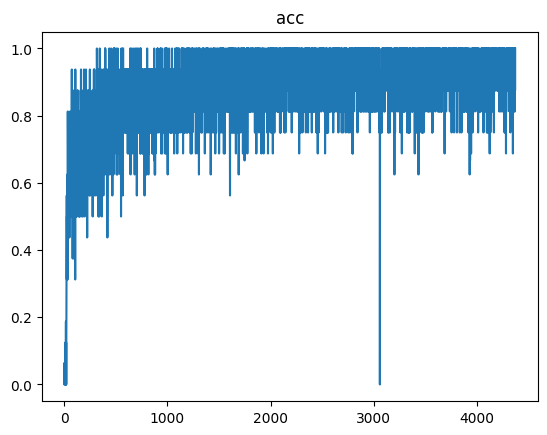

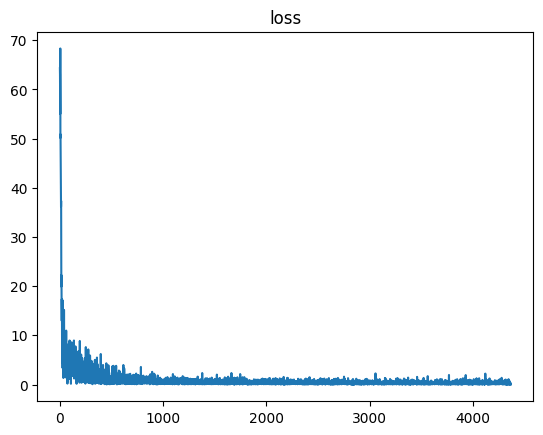

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc_list)
plt.title('acc')

plt.figure()
plt.plot(loss_list)
plt.title('loss')



- Plots training accuracy and loss over time for visual inspection of model performance and convergence.



The model is being trained to classify malware files into different types based on their raw byte content.
How it works:
- Input Data: Binary executable files (.exe or similar), read as raw bytes.

- Preprocessing:

  - Each file is converted into a fixed-length sequence of integers (each byte value + 1).

  - Short files are padded with zeros.

- Model Objective:

  - Learn patterns in the byte sequences that are characteristic of different malware families.

  - Output: A class label corresponding to a specific malware type/family.

  Each folder holds files of that malware type. The model learns to distinguish the byte-level patterns associated with each.

Paper for reference:
https://arxiv.org/pdf/1710.09435v1.pdf


# Adversarial Attacks

In [35]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for samples, labels in test_loader:
      samples = samples.type(torch.FloatTensor).cuda()
      labels = labels.cuda()

      outputs = model(samples.unsqueeze(1))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the test samples: {} %'.format((correct / total) * 100))

Accuracy of the model on the test samples: 94.41658308258107 %


# FGSM


In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def fgsm_attack(model, criterion, data, label, epsilon):
    data.requires_grad = True
    output = model(data.unsqueeze(0).unsqueeze(0))
    loss = criterion(output, label)

    model.zero_grad()
    loss.backward()

    # FGSM perturbation
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()

    perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data


In [51]:
model.eval()

epsilon = 0.05  # Perturbation strength
num_samples = 50

sample_count = 0
for data, label in test_loader:
    data = data.type(torch.FloatTensor).cuda()
    label = label.cuda()

    for i in range(len(data)):
        if sample_count >= num_samples:
            break

        sample = data[i].clone().detach().cuda()
        sample_label = label[i].unsqueeze(0)

        # FGSM adversarial example
        adv_sample = fgsm_attack(model, criterion, sample, sample_label, epsilon)

        # Predictions
        orig_pred = torch.argmax(model(sample.unsqueeze(0).unsqueeze(0)))
        adv_pred = torch.argmax(model(adv_sample.unsqueeze(0).unsqueeze(0)))

        print(f"Sample {sample_count + 1}: Original Prediction = {orig_pred.item()}, Adversarial Prediction (FGSM) = {adv_pred.item()}")

        # Visualization
        orig_np = sample.detach().cpu().numpy()
        adv_np = adv_sample.detach().cpu().numpy()
        diff = adv_np - orig_np

        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(orig_np)
        plt.title("Original Input")

        plt.subplot(1, 3, 2)
        plt.plot(adv_np)
        plt.title("Adversarial Input (FGSM)")

        plt.subplot(1, 3, 3)
        plt.plot(diff)
        plt.title("Perturbation (Δ)")

        plt.tight_layout()
        plt.show()

        sample_count += 1

    if sample_count >= num_samples:
        break

Output hidden; open in https://colab.research.google.com to view.

# PGD
- Repeatedly applies small FGSM steps.

- Keeps the perturbation within a bounded ε-ball (e.g., within ±0.05 of original input).

- More effective at fooling models than single-step FGSM.

In [52]:
def pgd_attack(model, criterion, data, label, epsilon=0.05, alpha=0.01, num_iter=10):
    original_data = data.clone().detach()
    perturbed_data = data.clone().detach().requires_grad_(True)

    for i in range(num_iter):

        output = model(perturbed_data.unsqueeze(0).unsqueeze(1))
        loss = criterion(output, label)

        model.zero_grad()
        loss.backward()

        # PGD step
        adv_data = perturbed_data + alpha * perturbed_data.grad.sign()

        # Project perturbation to epsilon-ball and clamp to valid range
        delta = torch.clamp(adv_data - original_data, min=-epsilon, max=epsilon)
        perturbed_data = torch.clamp(original_data + delta, min=0, max=1).detach().requires_grad_(True)

    return perturbed_data

In [53]:
model.eval()

epsilon = 0.05  # Max perturbation
alpha = 0.01    # Step size
num_iter = 10   # Iterations
num_samples = 50

sample_count = 0
for data, label in test_loader:
    data = data.type(torch.FloatTensor).cuda()
    label = label.cuda()

    for i in range(len(data)):
        if sample_count >= num_samples:
            break

        sample = data[i].clone().detach().cuda()
        sample_label = label[i].unsqueeze(0)

        # Generate PGD adversarial example
        pgd_adv_sample = pgd_attack(model, criterion, sample, sample_label, epsilon, alpha, num_iter)

        # Predictions
        orig_pred = torch.argmax(model(sample.unsqueeze(0).unsqueeze(1)))
        adv_pred = torch.argmax(model(pgd_adv_sample.unsqueeze(0).unsqueeze(1)))

        print(f"Sample {sample_count + 1}: Original Prediction = {orig_pred.item()}, Adversarial Prediction (PGD) = {adv_pred.item()}")

        # Visualization
        orig_np = sample.detach().cpu().numpy()
        adv_np = pgd_adv_sample.detach().cpu().numpy()
        diff = adv_np - orig_np

        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(orig_np)
        plt.title("Original Input")

        plt.subplot(1, 3, 2)
        plt.plot(adv_np)
        plt.title("Adversarial Input (PGD)")

        plt.subplot(1, 3, 3)
        plt.plot(diff)
        plt.title("Perturbation (Δ)")

        plt.tight_layout()
        plt.show()

        sample_count += 1

    if sample_count >= num_samples:
        break

Output hidden; open in https://colab.research.google.com to view.

In [54]:
model.eval()

epsilons = [0.05, 0.1, 0.2, 0.3]
alpha = 0.01
num_iter = 10
num_samples = 50  # Increase to get a better estimate

for eps in epsilons:
    print(f"--- Evaluating for Epsilon = {eps} ---")
    fgsm_success = 0
    pgd_success = 0
    sample_count = 0

    for data, label in test_loader:
        data = data.type(torch.FloatTensor).cuda()
        label = label.cuda()

        for i in range(len(data)):
            if sample_count >= num_samples:
                break

            sample = data[i].clone().detach().cuda()
            sample_label = label[i].unsqueeze(0)

            # FGSM attack
            adv_fgsm = fgsm_attack(model, criterion, sample, sample_label, eps)
            pred_fgsm = torch.argmax(model(adv_fgsm.unsqueeze(0).unsqueeze(0)))
            true_pred = torch.argmax(model(sample.unsqueeze(0).unsqueeze(0)))
            if pred_fgsm.item() != true_pred.item():
                fgsm_success += 1

            # PGD attack
            adv_pgd = pgd_attack(model, criterion, sample, sample_label, eps, alpha, num_iter)
            pred_pgd = torch.argmax(model(adv_pgd.unsqueeze(0).unsqueeze(0)))
            if pred_pgd.item() != true_pred.item():
                pgd_success += 1

            sample_count += 1

        if sample_count >= num_samples:
            break

    print(f"FGSM Attack Success Rate: {fgsm_success}/{num_samples} = {100 * fgsm_success / num_samples:.2f}%")
    print(f"PGD  Attack Success Rate: {pgd_success}/{num_samples} = {100 * pgd_success / num_samples:.2f}%")

--- Evaluating for Epsilon = 0.05 ---
FGSM Attack Success Rate: 12/50 = 24.00%
PGD  Attack Success Rate: 12/50 = 24.00%
--- Evaluating for Epsilon = 0.1 ---
FGSM Attack Success Rate: 12/50 = 24.00%
PGD  Attack Success Rate: 12/50 = 24.00%
--- Evaluating for Epsilon = 0.2 ---
FGSM Attack Success Rate: 12/50 = 24.00%
PGD  Attack Success Rate: 12/50 = 24.00%
--- Evaluating for Epsilon = 0.3 ---
FGSM Attack Success Rate: 12/50 = 24.00%
PGD  Attack Success Rate: 12/50 = 24.00%
